# 第三次讀書會：針對公投大選之主題探討

**Autor:** Group5<br>
**Date Created:** 2021/12/27<br>
**Last Modified:** 2021/12/18 <br>

本次讀書會將針對「公投大選」於PTT上的討論，進行社群上的圖學分析與應用。  
本次作業將先透過LDA為資料進行主題分析，再以不同角度、主題對社群進行篩選，進行網路分析。 

## 大綱

- 1. 載入套件
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 文章斷詞與整理
- 3. LDA
    - 3.1 LDA資料準備
    - 3.2 建立LDA
    - 3.3 資料內容探索
- 4. 社群網路圖
    - 4.1 基本網路圖
    - 4.2 資料篩選
    - 4.3 以日期篩選社群
    - 4.4 以主題篩選社群
    - 4.5 使用者是否受到歡迎

## 1. 載入套件

In [ ]:
import pandas as pd
import jieba
import re
from nltk import ngrams
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import networkx as nx
import numpy as np

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

## 2. 資料前處理

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT 政黑版2021/12/11 ~ 2021/12/17  所有文章
- 資料集： Assignment3_articleMetaData.csv; Assignment3_articleReviews.csv
- 關鍵字：公投、公民投票、核四、萊豬、藻礁、公投綁大選
- 資料時間：2021/12/11 ~ 2021/12/17 
- 資料筆數：共 1182 篇文章

> 這次我們針對2021/12/18所舉辦的公投，討論ptt版上相關討論的發文風向，主要針對以下方向分析：  
1.公投的討論重點有哪些? 主要分為哪幾種風向?  
2.風向最偏哪邊?  
3.討論公投的社群網路如何分布?  
4.公投的意見領袖有誰?網友的推噓狀態如何?

In [ ]:
data = pd.read_csv('Data/referendum_articleMetaData.csv', encoding='UTF-8')
review = pd.read_csv('Data/referendum_articleReviews.csv', encoding='UTF-8')
print(data.shape) 
data.head(5)

(1182, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[討論]公投的題目設定怪怪的吧！怎會雙重否定,2021/12/11,16:15:05,https://www.ptt.cc/bbs/HatePolitics/M.16392393...,yniori,HatePolitics,25,9,7,如題\n\n萊豬這題很怪\n\n是否同意禁止萊豬\n\n禁止是否定\n\n同意是肯定\n\n...
1,[討論]核四不重啟那核四的弊案會徹查究責嗎?,2021/12/11,17:40:09,https://www.ptt.cc/bbs/HatePolitics/M.16392444...,OPPAISuki,HatePolitics,16,2,4,核四不重啟 那核四的弊案會徹查究責嗎?\n\n3000億人民血汗錢蓋的耶! 就直接封存?\...
2,Re:[新聞]柯P被老婆爆料私下一句談論文門彭文正,2021/12/11,17:42:06,https://www.ptt.cc/bbs/HatePolitics/M.16392445...,neverfly,HatePolitics,5,2,0,針對陳總統夫人之夢的臉書文章，\n彭文正會表示歡迎是很合理的，\n而且還充滿了黑色幽默。\n...
3,[討論]能不能給我一個反萊豬的理由？,2021/12/11,17:59:00,https://www.ptt.cc/bbs/HatePolitics/M.16392455...,Yyh,HatePolitics,47,14,6,公投主文：你是否同意政府應全面禁止進口含有瘦肉精（萊克多巴胺等乙型受體素）豬隻\n之肉品、內...
4,Re:[討論]重工這次真的有在打侯友宜吔,2021/12/11,18:29:13,https://www.ptt.cc/bbs/HatePolitics/M.16392473...,OnlyRD,HatePolitics,15,3,0,國民黨內鬥啊\n國民黨現在最大的問題\n就是黨內有統派\n統派佔少數但是掌握很大資源\n看看...


In [ ]:
Reviews = data.iloc[:,0:-1].merge(review.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [ ]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': data.groupby('artDate').size().index,
    'count': data.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

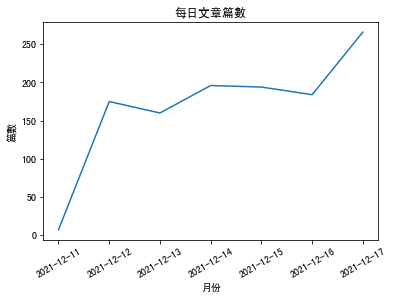

In [ ]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每日文章篇數') 
plt.xlabel('月份') 
plt.ylabel('篇數') 
plt.xticks(rotation=30) 
plt.show()

由此可知，每日文章數量從12/11開始有明顯上升的趨勢，並在公投大選前一天12/17達到高點。

### 2.2 文章斷詞語整理

### Creat dictonary

In [ ]:
jieba.set_dictionary('./dict/dict.txt.big')

with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
referendum_bigram_Meta = pd.DataFrame(data['sentence'].astype(str))
referendum_bigram_Meta["word"] = referendum_bigram_Meta.sentence.apply(bigram_getToken)
referendum_bigram_Meta = referendum_bigram_Meta.explode('word')
referendum_bigram_Meta.head(3)
referendum_bigram_Meta_count = referendum_bigram_Meta.groupby(["word"],as_index=False).size()

Building prefix dict from /Users/yiiixian/Desktop/社群媒體分析/studygroup3/dict/dict.txt.big ...
Loading model from cache /var/folders/kk/hmwxhtss55ld73n__k3x5_k00000gn/T/jieba.ue8e1aa15da09eed82a13ed838ee590b8.cache
Loading model cost 1.364 seconds.
Prefix dict has been built successfully.


In [ ]:
referendum_bigram_Reviews = review.copy()
referendum_bigram_Reviews["word"] = referendum_bigram_Reviews.cmtContent.apply(bigram_getToken)
referendum_bigram_Reviews = referendum_bigram_Reviews.explode('word')
referendum_bigram_Reviews.head(3)
referendum_bigram_Reviews_count = referendum_bigram_Reviews.groupby(["word"],as_index=False).size()

### 資料斷詞

In [ ]:
jieba.set_dictionary('./dict/dict.txt.big') 

jieba.load_userdict('./dict/referendum.txt')

Building prefix dict from /Users/yiiixian/Desktop/社群媒體分析/studygroup3/dict/dict.txt.big ...
Loading model from cache /var/folders/kk/hmwxhtss55ld73n__k3x5_k00000gn/T/jieba.ue8e1aa15da09eed82a13ed838ee590b8.cache
Loading model cost 1.373 seconds.
Prefix dict has been built successfully.


In [ ]:
new_data = data[['artUrl','sentence']]
new_data = pd.DataFrame(new_data['sentence'].astype(str))
token_df = new_data.assign(wordlist = new_data['sentence'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)


,sentence,wordlist
0,如題\n\n萊豬這題很怪\n\n是否同意禁止萊豬\n\n禁止是否定\n\n同意是肯定\n\n...,"[如, 題, \n, \n, 萊豬, 這題, 很, 怪, \n, \n, 是否, 同意, 禁..."
1,核四不重啟 那核四的弊案會徹查究責嗎?\n\n3000億人民血汗錢蓋的耶! 就直接封存?\...,"[核四, 不, 重啟, , , 那核, 四, 的, 弊案, 會徹, 查究, 責, 嗎, ..."
2,針對陳總統夫人之夢的臉書文章，\n彭文正會表示歡迎是很合理的，\n而且還充滿了黑色幽默。\n...,"[針對, 陳, 總統, 夫人, 之夢, 的, 臉書, 文章, ，, \n, 彭文, 正會, ..."


In [ ]:
stopwords = []

with open(f'./dict/stopwords.txt','r') as f:
    stopwords = f.read().splitlines() 
user_stop = ['真的','投票','支持','政府','新聞']
for i in user_stop:
    stopwords.append(i)

def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [re.sub('[^\u4e00-\u9fa5]+', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result


In [ ]:
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,sentence,wordlist,remove_stopwords
0,如題\n\n萊豬這題很怪\n\n是否同意禁止萊豬\n\n禁止是否定\n\n同意是肯定\n\n...,"[如, 題, \n, \n, 萊豬, 這題, 很, 怪, \n, \n, 是否, 同意, 禁...","[萊豬, 這題, 同意, 禁止, 萊豬, 禁止, 否定, 同意, 肯定, 同意, 否定, 同..."
1,核四不重啟 那核四的弊案會徹查究責嗎?\n\n3000億人民血汗錢蓋的耶! 就直接封存?\...,"[核四, 不, 重啟, , , 那核, 四, 的, 弊案, 會徹, 查究, 責, 嗎, ...","[核四, 重啟, 那核, 弊案, 會徹, 查究, 血汗錢, 封存, 經手, 核四, 官員, ..."
2,針對陳總統夫人之夢的臉書文章，\n彭文正會表示歡迎是很合理的，\n而且還充滿了黑色幽默。\n...,"[針對, 陳, 總統, 夫人, 之夢, 的, 臉書, 文章, ，, \n, 彭文, 正會, ...","[總統, 夫人, 之夢, 臉書, 文章, 彭文, 正會, 充滿, 黑色幽默, 總統, 夫人,..."


## 3. LDA主題模型

## 3.1 LDA資料準備

In [ ]:
token_data = token_df['remove_stopwords'].tolist()

In [ ]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(19193 unique tokens: ['同意', '否定', '命題', '夠爛', '就問']...)


In [ ]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 8), (1, 4), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 5), (9, 1)]


## 3.2 建立建立LDA 

In [ ]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=3, # 生成幾個主題數
    random_state=35, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

In [ ]:

topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.020*"公投" + 0.014*"台灣" + 0.010*"民進黨" + 0.009*"美國" + 0.008*"國民黨" + 0.006*"萊豬" + 0.005*"同意"')
(1, '0.018*"公投" + 0.011*"侯友宜" + 0.008*"國民黨" + 0.008*"民進黨" + 0.006*"同意" + 0.005*"台灣" + 0.004*"表態"')
(2, '0.018*"同意" + 0.017*"台灣" + 0.015*"公投" + 0.009*"民進黨" + 0.009*"國民黨" + 0.008*"核四" + 0.004*"美國"')


**可以歸納出**
- topic 0 = “關於萊豬公投的討論議題”
- topic 1 = “關於藍綠兩黨對於公投表態的問題”
- topic 2 = “關於核四的討論”  

<b><mark><font color=red>*以下我們有將三個主題皆進行比較。 </font></mark></b>   

In [ ]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -1.389759895161476


In [ ]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.758763254182522


In [ ]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.750241,6312.207464
1,4,-8.801325,6643.039947
2,6,-8.833537,6860.510273
3,8,-8.862796,7064.204092


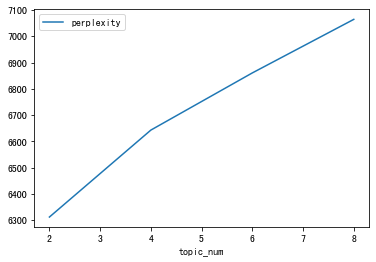

In [ ]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

由此可知，將資料分成二或三個主題，是較佳的模型結果。

## 3.3 資料資料內容探索

#### 主題模型：視覺化

In [ ]:
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=2, # 生成幾個主題數
    random_state=2500, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)

In [ ]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's d

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

In [ ]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list
data.artDate = pd.to_datetime(data['artDate'])

In [ ]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()


In [ ]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2']
date_df = date_df.set_index('artDate')
date_df


,topic0,topic1,topic2
artDate,,,
2021-12-11,2,2,3
2021-12-12,56,50,69
2021-12-13,49,52,59
2021-12-14,58,66,72
2021-12-15,59,69,66
2021-12-16,61,42,81
2021-12-17,110,64,92


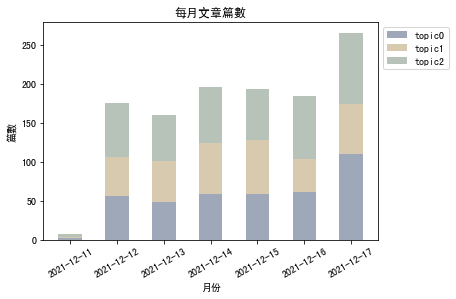

In [ ]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8"]
column = ['topic0', 'topic1', 'topic2']
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以得知每個主題的文章篇數討論並無明顯差異，而在公投前一天(2021/12/17）的文章討論數量為最高峰，且主題二的討論量略多。

In [ ]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 

for i in range(0,3):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,sum
artDate,,,,
2021-12-11,0.285714,0.285714,0.428571,7
2021-12-12,0.320000,0.285714,0.394286,175
2021-12-13,0.306250,0.325000,0.368750,160
2021-12-14,0.295918,0.336735,0.367347,196
2021-12-15,0.304124,0.355670,0.340206,194
2021-12-16,0.331522,0.228261,0.440217,184
2021-12-17,0.413534,0.240602,0.345865,266


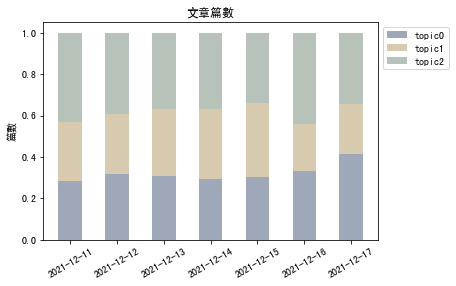

In [ ]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8"]
column = ['topic0', 'topic1', 'topic2']

temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=0.5)

plt.title('文章篇數') # 標題
plt.xlabel('') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以得知每個主題的文章佔比並無極度明顯差異，推論可能是網友在討論公投議題時並不會有明顯的主題分類，會將各項議題進行綜合性、全面性的討論。

## 4. 社群網路圖
運用圖論(Graph theory)，從這些節點和連結去研究人與人之間的關係以及討論公投的整個群體結構。

## 4.1 基本網絡圖

In [ ]:
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [ ]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,[討論]公投的題目設定怪怪的吧！怎會雙重否定,2021-12-11,16:15:05,https://www.ptt.cc/bbs/HatePolitics/M.16392393...,yniori,HatePolitics,25,9,7,如題\n\n萊豬這題很怪\n\n是否同意禁止萊豬\n\n禁止是否定\n\n同意是肯定\n\n...,2,charles0939,→,:聯手賴品妤反核賴清德感性催投「4個不同意」,:聯手賴品妤反核賴清德感性催投「4個不同意」
1,[討論]公投的題目設定怪怪的吧！怎會雙重否定,2021-12-11,16:15:05,https://www.ptt.cc/bbs/HatePolitics/M.16392393...,yniori,HatePolitics,25,9,7,如題\n\n萊豬這題很怪\n\n是否同意禁止萊豬\n\n禁止是否定\n\n同意是肯定\n\n...,2,Pietro,推,:2018年就一堆考考妣妣被True／False搞到只能看小抄。然,:2018年就一堆考考妣妣被True／False搞到只能看小抄。然


In [ ]:
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,charles0939,yniori,https://www.ptt.cc/bbs/HatePolitics/M.16392393...
1,Pietro,yniori,https://www.ptt.cc/bbs/HatePolitics/M.16392393...
2,Pietro,yniori,https://www.ptt.cc/bbs/HatePolitics/M.16392393...
3,scorpio0920,yniori,https://www.ptt.cc/bbs/HatePolitics/M.16392393...
4,xox5678,yniori,https://www.ptt.cc/bbs/HatePolitics/M.16392393...


In [ ]:
len(link)

32865

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，總共有32865筆資料

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


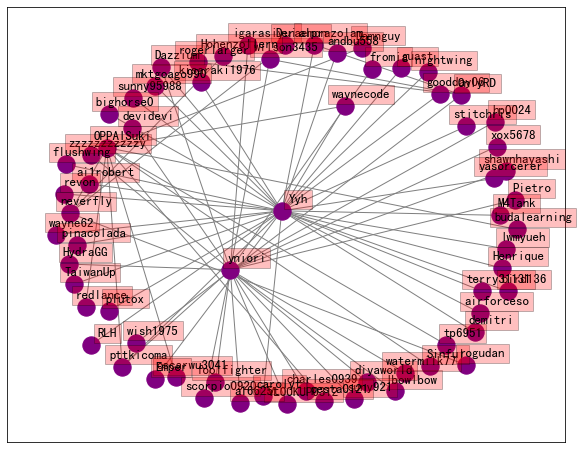

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜，多達32865筆資料，所以需要進行下一步篩選。

## 4.2 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

Text(0, 0.5, 'count')

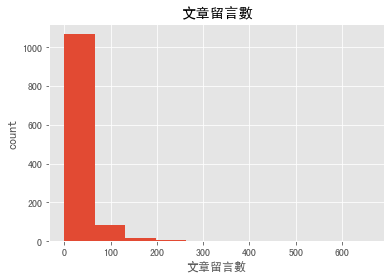

In [ ]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

依據發文數或回覆數篩選post和review

In [ ]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
283,nicholas0406,19
129,chen740530,18
209,ismail,17
17,Ferrara,17
355,takuminauki,17
...,...,...
1,Abobe,1
206,ieqingz,1
207,ikoo,1
208,ilovedt,1


In [ ]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 409
回覆者數量總共: 2957


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [ ]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [ ]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [ ]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")

In [ ]:
allPoster.head(5)

,user,type
0,qwertyuioplk,replayer
1,lenfeng,replayer
2,saten,replayer
3,yaieki,replayer
4,RyanMulderII,replayer


## 4.3 以日期篩選社群

公投大選時間為12/18，我們挑出前一天的文章和回覆

In [ ]:
posts_Reviews_1217 = (posts_Reviews.query('artDate == "2021-12-17"')
                      .query('commentNum>80')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [ ]:
# 篩選有人在同一篇文章重複回覆大於3次
posts_Reviews_1217 = posts_Reviews_1217.query('size>3')
posts_Reviews_1217.head(3)

,cmtPoster,artUrl,size
0,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397256...,35
1,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,7
26,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,4


In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1217 = pd.merge(posts_Reviews_1217,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1217.reset_index(inplace=True, drop=True) #重設index
link_1217.head(3)

,cmtPoster,artUrl,size,artPoster
0,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397256...,35,thinboy543
1,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,7,ysb727
2,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,4,ysb727


In [ ]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_1217)):
    G.add_edge(link_1217["cmtPoster"][i], link_1217["artPoster"][i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


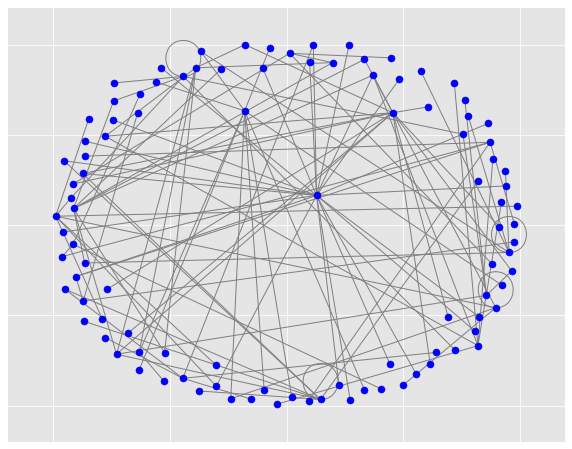

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

**加上nodes的顯示資訊**  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['thinboy543', 'ysb727', 'tenfu', 'akway', 'Stunts']

In [ ]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


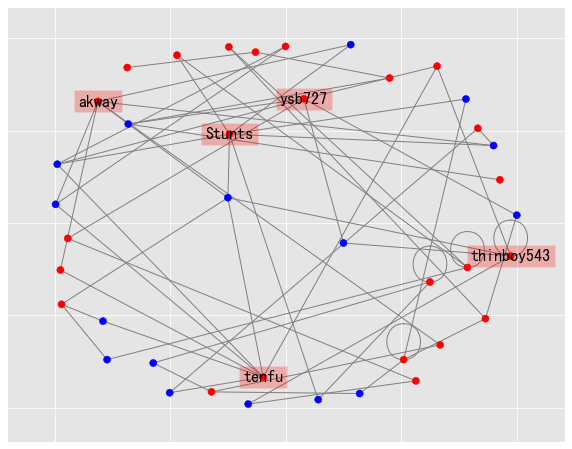

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    

plt.show()


In [ ]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'AdwaSgibin': 0.05128205128205128,
 'thinboy543': 0.15384615384615385,
 'ysb727': 0.15384615384615385,
 'Yolosnow': 0.05128205128205128,
 'tenfu': 0.1794871794871795,
 'yniori': 0.05128205128205128,
 'purue': 0.07692307692307693,
 'Sentimental': 0.05128205128205128,
 'akway': 0.15384615384615385,
 'Stunts': 0.1794871794871795,
 'Sinful': 0.05128205128205128,
 'newsyho': 0.1282051282051282,
 'makoto1982': 0.07692307692307693,
 'Sinreigensou': 0.05128205128205128,
 'gerund': 0.02564102564102564,
 'jason486': 0.05128205128205128,
 'TheoEpstein': 0.05128205128205128,
 'WTF55665566': 0.07692307692307693,
 'cheinshin': 0.02564102564102564,
 'a10141013': 0.05128205128205128,
 'peter308': 0.05128205128205128,
 'lwt501cx': 0.1282051282051282,
 'benqlove': 0.07692307692307693,
 'demonh311': 0.05128205128205128,
 'foolfighter': 0.07692307692307693,
 'jacklyl': 0.07692307692307693,
 'goldenfire': 0.05128205128205128,
 'iamdota': 0.10256410256410256,
 'indium111': 0.05128205128205128,
 'jess730612

In [ ]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [ ]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:108: DeprecationWarning: networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  G, alpha, personalization, max_iter, tol, nstart, weight, dangling


In [ ]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [ ]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['tenfu', 'Stunts', 'thinboy543', 'ysb727', 'akway']
eigenvector centrality: ['tenfu', 'jess730612', 'Stunts', 'akway', 'thinboy543']
pagerank centrality: ['Stunts', 'tenfu', 'ysb727', 'akway', 'thinboy543']
betweenness centrality: ['ysb727', 'Stunts', 'iamdota', 'jess730612', 'WTF55665566']


不同的centraility計算方式會得到不同的結果，但前兩名幾乎有出現'tenfu' & 'Stunts'。

## 4.4 以主題篩選社群

挑選出2021-12-17當天的文章， 篩選一篇文章回覆3次以上者，文章主題歸類為0（萊豬）1（表態）及2（核電）者， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [ ]:
# 加上topic
topic_1217 = pd.merge(link_1217,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1212_topic = pd.merge(topic_1217,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1212_topic.reset_index(inplace=True, drop=True) #重設index
link_1212_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397256...,0,thinboy543
1,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,1,ysb727
2,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,1,ysb727


In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_1212_topic)):
    G.add_edge(link_1212_topic["cmtPoster"][i], link_1212_topic["artPoster"][i])
    if link_1212_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:萊豬
    elif link_1212_topic["topic"][i] == 1:  
        color_map_edge.append('grey') #主題一：表態
    else :
        color_map_edge.append('green') #主題二：核電

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


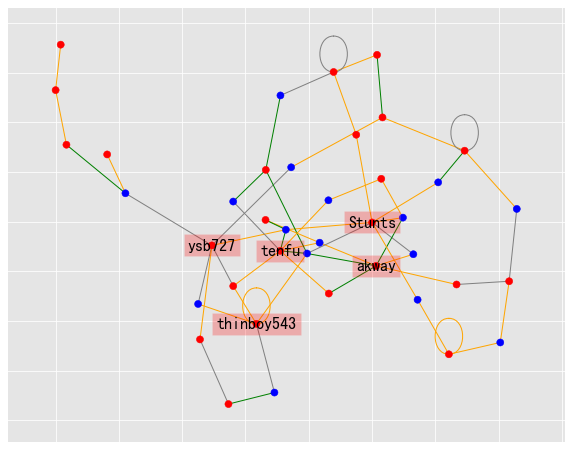

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

可以發現以萊豬（橘色）的討論為多；而Stunts和thinboy543較多為萊豬相關留言、akway和tenfu有較多的核電（綠色）相關留言、ysb727則有較多討論政黨表態（灰色）的留言。

## 4.5 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓二者，因此把箭頭清掉。

In [ ]:
# 加上status
status_1217 = pd.merge(link_1217,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1217 = status_1217[status_1217["cmtStatus"]!="→"]

In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1217_status = pd.merge(status_1217,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1217_status.reset_index(inplace=True, drop=True) #重設index
link_1217_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397256...,0,推,thinboy543
1,AdwaSgibin,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,1,推,ysb727
2,CYL009,https://www.ptt.cc/bbs/HatePolitics/M.16397295...,1,推,ysb727


In [ ]:
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1217_status)):
    G.add_edge(link_1217_status["cmtPoster"][i], link_1217_status["artPoster"][i])
    if link_1217_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')   

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


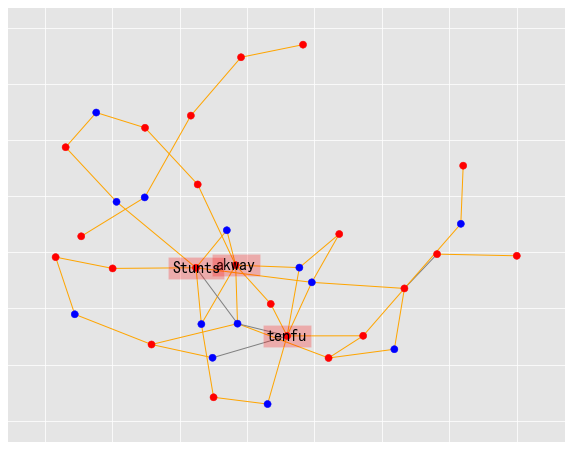

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

可以發現本次的討論中幾乎都是推文、噓文較少